In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warehouse_env as wh
from agents import TDControl_Agent, DQN_Agent, state_to_tensor, evaluate_success_rate, watch_agent_perform
from plot_utils import plot_steps_rewards, plot_qvalues_slice, plot_policy_slice, plot_success_rate
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import random
from IPython.display import clear_output

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


# **Part 1: Q-Learning vs. SARSA**

Parameters:

In [3]:
n_episodes = 60000
num_rows = 5
num_cols = 5
num_crates = 3
tstar = 20000  # epsilon decay start time
Epsilons_0 = [0.10, 0.15, 0.20]
LRs_0 = [0.05, 0.12, 0.20]
Gamma = [0.95, 0.98, 0.99]

# Example state used to plot q-values and policies later; adjust as needed.
# fixed_positions only contains the non-active crates positions. 
example_fixed_state1 = {
    "active_id": 0,
    "fixed_positions": {
        1: (4, 1),
        2: (2, 3)
    }
}

Visualize a sample starting state:

In [4]:
env = wh.WarehouseEnv(rows=num_rows, cols=num_cols, num_crates=num_crates, reward=20)

s, _ = env.reset()
print("Starting state (sample):\n")
print(f"s := {s}\n")
env.render()

Starting state (sample):

s := {'active_crate_id': np.int32(0), 'crate_positions': array([[1, 1],
       [2, 1],
       [1, 4]], dtype=int32)}

[G]  .   .   .   . 
 G   A1  .   .   a3
 G   a2  .   .   . 
 .   .   .   .   . 
 .   .   .   .   . 



TD Control main training loop

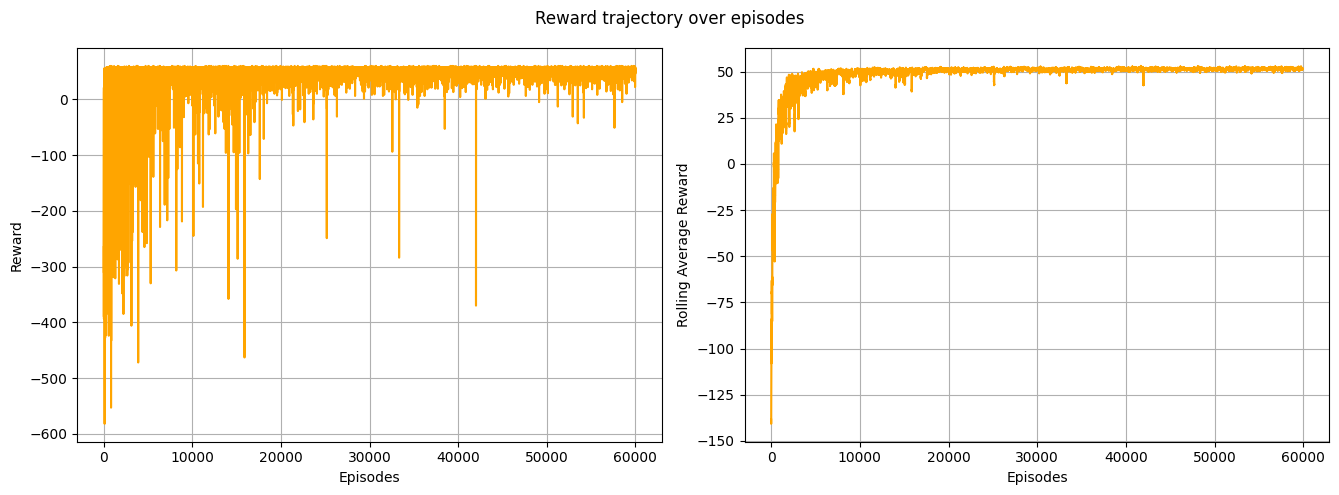

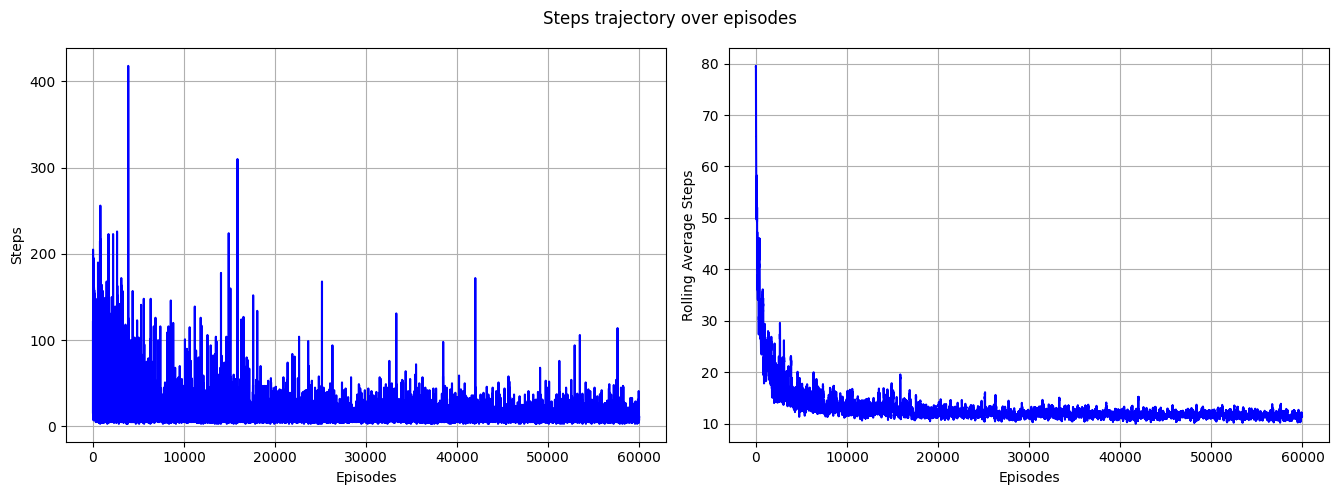

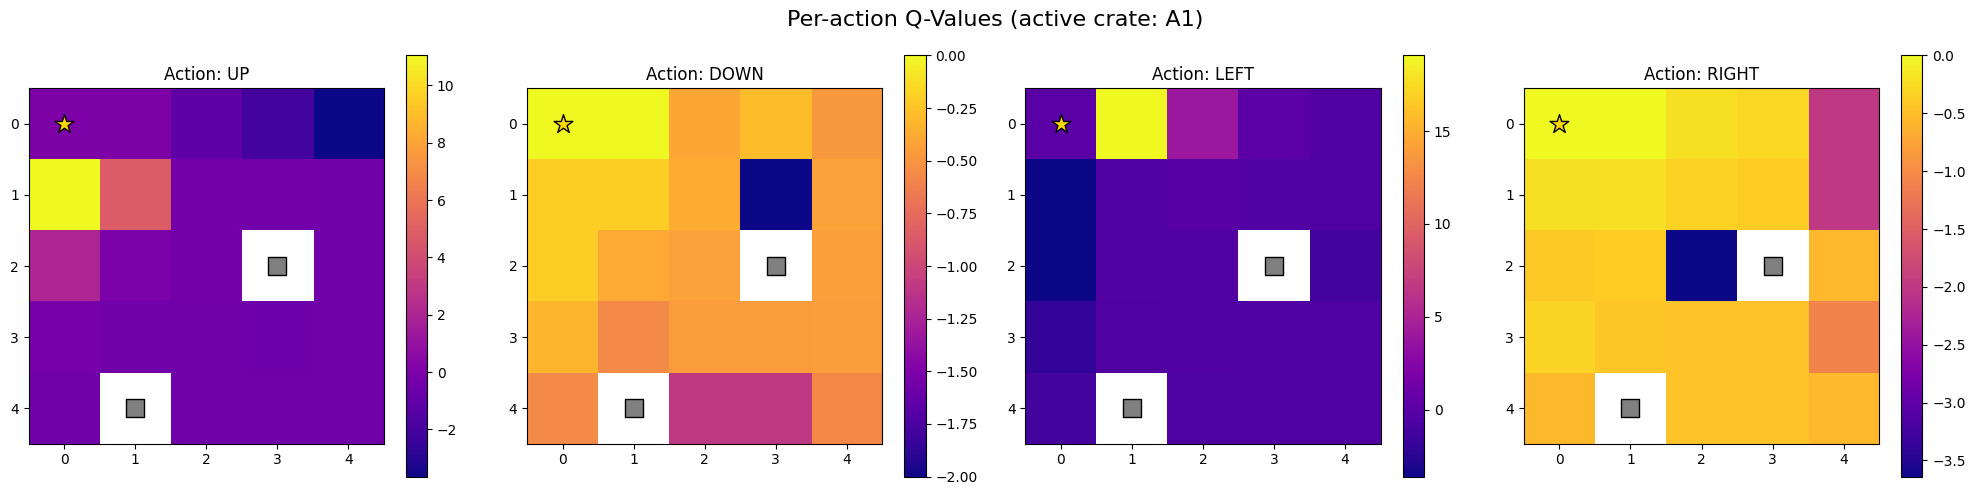

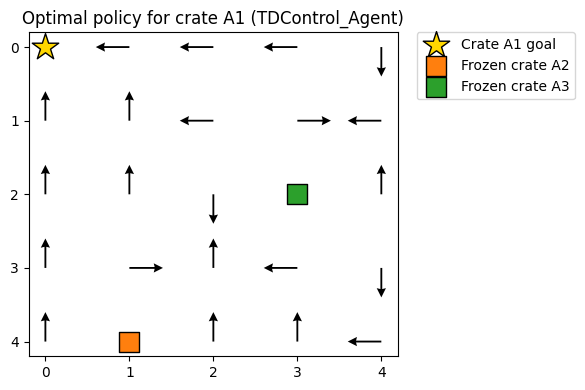

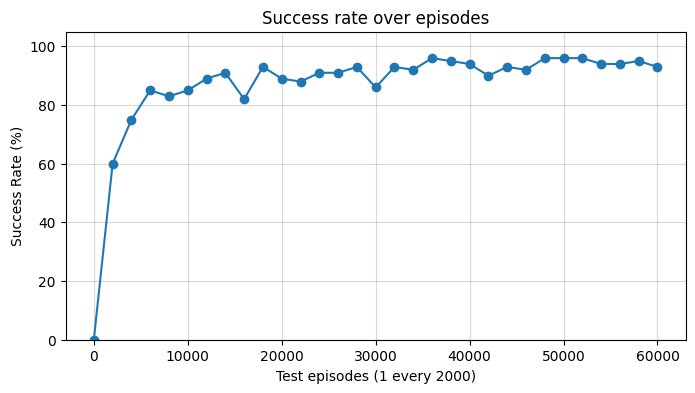


Total time steps: 778814

Total theoretical states: 41400
Visited states: 5449


In [5]:
for epsilon_0 in Epsilons_0:
    for lr_0 in LRs_0:
        for gamma in Gamma:

            # -----------------------------------------------------------------------------------
            # Variables and parameters used for tests and logging
            # 1. Every 2000 episodes, test the agent for 100 episodes of max 100 steps each, and record the success rate
            count = 0
            success_rate_trajectory = []
            test_indexes = []

            # 2. Reward and Steps trajectories
            reward_trajectory = np.zeros(n_episodes)       # hopefully higher as episodes increase
            steps_per_episode = np.zeros(n_episodes)       # hopefully lower as episodes increase 
            # -----------------------------------------------------------------------------------

            env = wh.WarehouseEnv(rows=num_rows, cols=num_cols, num_crates=num_crates, reward=20)
            AGENT = TDControl_Agent(action_size=env.action_space.n, gamma=gamma, lr=lr_0)
            epsilon = epsilon_0

            clear_output(wait=True)

            for i in range(n_episodes):
                done = False
                steps = 0

                # Test mode every 2000 episodes
                if i%2000 == 0 or i==n_episodes-1:
                    rate = evaluate_success_rate(AGENT, env, num_test_episodes=100, max_steps_per_episode=100)
                    success_rate_trajectory.append(rate)
                    test_indexes.append(i+1)

                s, _ = env.reset()
                a = AGENT.get_action_epsilon_greedy(s, epsilon)     # 0, 1, 2, 3
                
                while not done:

                    count +=1       # Reminder that "count" is for total steps, while "steps" is per-episode
                    steps +=1
                    # Evolve one step
                    new_s, r, terminated, truncated, _ = env.step(a)
                    done = terminated or truncated
                    
                    # Keeps track of performance for each episode
                    reward_trajectory[i] += r
                    
                    # Choose new action index
                    new_a = AGENT.get_action_epsilon_greedy(new_s, epsilon)

### Change this function if you want either SARSA or Q-Learning ----------------------------
                    AGENT.single_step_update_QL(s, a, r, new_s, done)
### ----------------------------------------------------------------------------------------

                    if count > tstar:
                        AGENT.alpha = lr_0 / (1 + 0.003*(count - tstar)**0.75)
                        epsilon = epsilon_0 / (1. + 0.005*(count - tstar)**1.05)
                    
                    a = new_a
                    s = new_s
                    
                steps_per_episode[i] += steps

                #if i%100 == 0 or i==n_episodes-1:
                #    print(f"Episode: {i}, Epsilon: {epsilon}")

### Plot & saving --------------------------------------------------------------------------      
            eps0_alias = format(epsilon_0, ".2f")[2:]
            lr0_alias = format(lr_0, ".2f")[2:]
            gam_alias = format(gamma, ".2f")[2:]
            config_folder = "results/eps" + eps0_alias + "/lr" + lr0_alias + "/gam" + gam_alias + "/"
        # --> e.g., save path for epsilon_0=0.20, lr_0=0.12, gamma=0.99:   config_folder == "eps20/lr12/gam99/"

            #os.makedirs(config_folder, exist_ok=True)

            plot_steps_rewards(n_episodes, reward_trajectory, display_mode="reward")#, save_path=config_folder + "reward.png")
            plot_steps_rewards(n_episodes, steps_per_episode, display_mode="steps")#, save_path=config_folder + "steps.png")
            plot_qvalues_slice(AGENT, env, example_fixed_state1)#, save_path=config_folder + "qvalues.png")
            plot_policy_slice(AGENT, env, example_fixed_state1)#, save_path=config_folder + "policy.png")
            plot_success_rate(test_indexes, success_rate_trajectory)#, save_path=config_folder + "success_rate.png")

            #print("Ending state (final episode):\n")
            #env.render()
### ----------------------------------------------------------------------------------------

            Qvalues = AGENT.Qvalues
            print(f"\nTotal time steps: {count}")
            print(f"\nTotal theoretical states: {len(env)}")
            print(f"Visited states: {len(Qvalues)}")

# **Part 2: Q-Learning vs. DQN**

Parameters:

In [3]:
# Shared
N_EPISODES = 20000
ENV_ROWS = 5
ENV_COLS = 5
ENV_CRATES = 3
GAMMA = 0.99

# Q-Learning    (Best parameters found previously: eps=0.10, lr=0.20, gamma=0.99)
EPSILON_0 = 0.20
LR_QL = 0.20
TSTAR = 10000

# DQN
EPSILON_START = 0.9     # High at the start to build memory
EPSILON_END   = 0.05
EPSILON_DECAY = 0.999
LR_DQN = 0.001
BUFFER_SIZE = 10000
BATCH_SIZE = 128
TARGET_UPDATE_FREQUENCY = 10     # Target network episode number update

## Q-Learning Agent training

In [4]:
env_ql = wh.WarehouseEnv(rows=ENV_ROWS, cols=ENV_COLS, num_crates=ENV_CRATES, reward=20)
QL = TDControl_Agent(action_size=env_ql.action_space.n, gamma=GAMMA, lr=LR_QL)

reward_trajectory_QL = np.zeros(N_EPISODES)       # hopefully higher as episodes increase
steps_per_episode_QL = np.zeros(N_EPISODES)       # hopefully lower as episodes increase 

count = 0
epsilon = EPSILON_0

for i in range(N_EPISODES):
    done = False
    steps = 0

    s, _ = env_ql.reset()
    a = QL.get_action_epsilon_greedy(s, epsilon)     # 0, 1, 2, 3
    
    while not done:

        count +=1
        steps +=1
        # Evolve one step
        new_s, r, terminated, truncated, _ = env_ql.step(a)
        done = terminated or truncated
        
        # Keeps track of performance for each episode
        reward_trajectory_QL[i] += r
        
        # Choose new action index
        new_a = QL.get_action_epsilon_greedy(new_s, epsilon)

### Change this function if you want either SARSA or Q-Learning ----------------------------
        _ = QL.single_step_update_QL(s, a, r, new_s, done)
### ----------------------------------------------------------------------------------------

        if count > TSTAR:
            QL.alpha = LR_QL / (1 + 0.003*(count - TSTAR)**0.75)
            epsilon = EPSILON_0 / (1. + 0.005*(count - TSTAR)**1.05)
        
        a = new_a
        s = new_s
        
    steps_per_episode_QL[i] += steps

Qvalues = QL.Qvalues
print(f"\nTotal time steps: {count}")
print(f"\nTotal theoretical states: {len(env_ql)}")
print(f"Visited states: {len(Qvalues)}")


Total time steps: 316195

Total theoretical states: 41400
Visited states: 5350


## DQN Agent training

In [6]:
env_dqn = wh.WarehouseEnv(rows=ENV_ROWS, cols=ENV_COLS, num_crates=ENV_CRATES, reward=20)
DQN = DQN_Agent(env_dqn, GAMMA, EPSILON_START, EPSILON_END, EPSILON_DECAY, LR_DQN, BUFFER_SIZE, BATCH_SIZE, device=device)

reward_trajectory_DQN = np.zeros(N_EPISODES)       # hopefully higher as episodes increase
steps_per_episode_DQN = np.zeros(N_EPISODES)       # hopefully lower as episodes increase 

for i in range(N_EPISODES):
    done = False
    steps = 0
    
    s, _ = env_dqn.reset()
    
    while not done:

        steps += 1
        s_tensor = state_to_tensor(s, env_dqn).to(DQN.device)
        a_tensor = DQN.select_action(s_tensor)
        a = a_tensor.item()
        
        new_s, r, terminated, truncated, _ = env_dqn.step(a)
        done = terminated or truncated

        reward_trajectory_DQN[i] += r
        
        # Convert to tensors to store in experience buffer
        r_tensor = torch.tensor([r], device=DQN.device)
        done_tensor = torch.tensor([done], device=DQN.device, dtype=torch.float32)
        new_s_tensor = state_to_tensor(new_s, env_dqn).to(DQN.device)
        
        # Buffer update
        DQN.buffer.push(s_tensor, a_tensor, r_tensor, new_s_tensor, done_tensor)
        
        s = new_s
        
        # Execute a learning step
        DQN.learn()

    steps_per_episode_DQN[i] += steps
    
    if i == 0 or (i+1) % 500 == 0:
        print(f"Episode {i+1}/{N_EPISODES}")
    
    if (i+1) % TARGET_UPDATE_FREQUENCY == 0:
        DQN.update_target_net()

print(f"\nTotal theoretical states: {len(env_dqn)}")

Episode 1/20000
Episode 500/20000
Episode 1000/20000
Episode 1500/20000
Episode 2000/20000
Episode 2500/20000
Episode 3000/20000
Episode 3500/20000
Episode 4000/20000
Episode 4500/20000
Episode 5000/20000
Episode 5500/20000
Episode 6000/20000
Episode 6500/20000
Episode 7000/20000
Episode 7500/20000
Episode 8000/20000
Episode 8500/20000
Episode 9000/20000
Episode 9500/20000
Episode 10000/20000
Episode 10500/20000
Episode 11000/20000
Episode 11500/20000
Episode 12000/20000
Episode 12500/20000
Episode 13000/20000
Episode 13500/20000
Episode 14000/20000
Episode 14500/20000
Episode 15000/20000
Episode 15500/20000
Episode 16000/20000
Episode 16500/20000
Episode 17000/20000
Episode 17500/20000
Episode 18000/20000
Episode 18500/20000
Episode 19000/20000
Episode 19500/20000
Episode 20000/20000

Total theoretical states: 41400


In [7]:
final_success_rate_QL = evaluate_success_rate(QL, env_ql, num_test_episodes=250,max_steps_per_episode=100)
final_success_rate_DQN = evaluate_success_rate(DQN, env_dqn, num_test_episodes=250,max_steps_per_episode=100)

print(f"Success rate of Q-Learning Agent: {final_success_rate_QL:.2f}%")
print(f"Success rate of DQN Agent: {final_success_rate_DQN:.2f}%")

Success rate of Q-Learning Agent: 84.40%
Success rate of DQN Agent: 100.00%


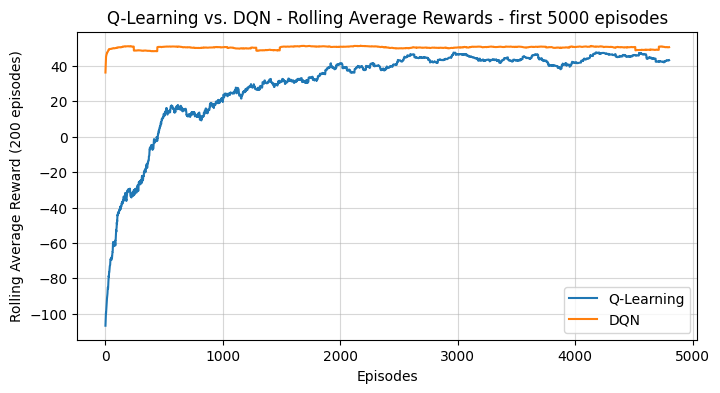

In [8]:
plt.figure(figsize=(8, 4))

window = 200
rolling_avg_ql = np.convolve(reward_trajectory_QL[:5000], np.ones(window)/window, mode='valid')
rolling_avg_dqn = np.convolve(reward_trajectory_DQN[:5000], np.ones(window)/window, mode='valid')

plt.plot(rolling_avg_ql, label='Q-Learning')
plt.plot(rolling_avg_dqn, label='DQN')

plt.title(f"Q-Learning vs. DQN - Rolling Average Rewards - first 5000 episodes")
plt.xlabel("Episodes")
plt.ylabel("Rolling Average Reward (200 episodes)")
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()

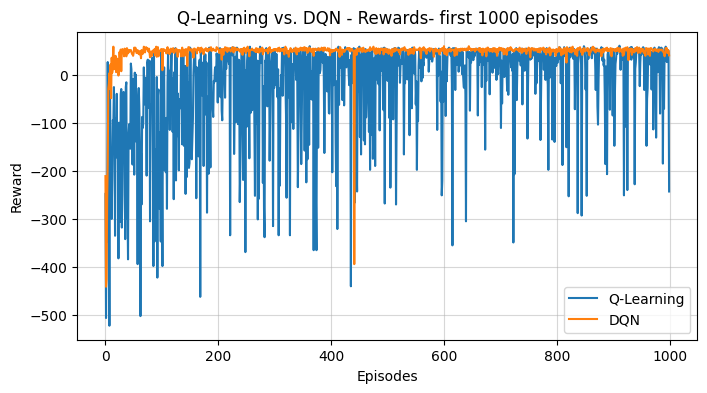

In [9]:
plt.figure(figsize=(8, 4))

plt.plot(reward_trajectory_QL[:1000], label='Q-Learning')
plt.plot(reward_trajectory_DQN[:1000], label='DQN')

plt.title(f"Q-Learning vs. DQN - Rewards- first 1000 episodes")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()

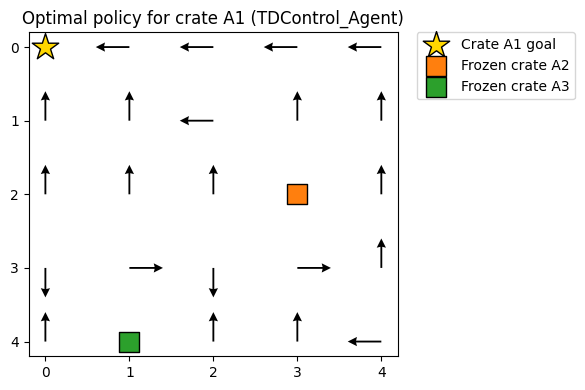

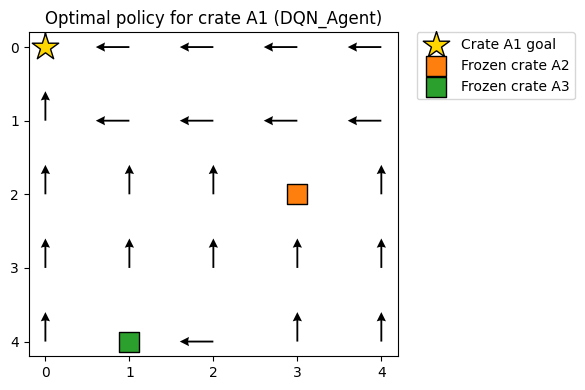

In [10]:
example_fixed_state2= {
    "active_id": 0, 
    "fixed_positions": {1: (2, 3), 
                        2: (4, 1), } 
}
plot_policy_slice(QL, env_ql, example_fixed_state2)
plot_policy_slice(DQN, env_dqn, example_fixed_state2)

In [11]:
watch_agent_perform(QL, env_ql)

 X   .   .   .   . 
 X   .   .   .   . 
 X   .   .   .   . 
 .   .   .   .   . 
 .   .   .   .   . 


Success. The agent sorted the crates in 9 steps.

Total reward: 54


In [12]:
watch_agent_perform(DQN, env_dqn)

 X   .   .   .   . 
 X   .   .   .   . 
 X   .   .   .   . 
 .   .   .   .   . 
 .   .   .   .   . 


Success. The agent sorted the crates in 15 steps.

Total reward: 48
